In [36]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [37]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [38]:
warnings.filterwarnings("ignore")

In [39]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(column)

    plt.show()

In [40]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        valid_values = [value for value in window if not pd.isna(value)]
        if len(valid_values) > 0:
            moving_averages.append(np.mean(valid_values))
        else:
            moving_averages.append(np.nan)

    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [52]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [53]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

In [54]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('dados_imobilidarios_bcb.csv')
df.head(len(df))

,DateTime,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
0,2014-04-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-05-31,4.824127e+07,2.739426e+08,2.397400e+09,2.675238e+09,6.697185e+09,4.018676e+08,2.097543e+07,2.524422e+09,5.325400e+08,2.781119e+11,1.959286e+10,NaN,3.313491e+11,9986814.34,6.863815e+08,1.291710e+09,8.923534e+09,8.904868e+09,2.904066e+07,3.033041e+08,5.431576e+07,1.966174e+08,6.003065e+08,1.043507e+10,5.890078e+10,1.240389e+11,1.849836e+11,1.804470e+09,1.861537e+09,2.292384e+10,2.677901e+10,1.45,2.57,1.44,1.10,4.53,0.32,0.50,0.58,0.01,485037160050,1.366089e+09,NaN,4.079555e+10,1.172959e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-30,4.567950e+07,4.306805e+08,2.080355e+09,2.943574e+09,5.689549e+09,1.798253e+08,7.297202e+07,1.200276e+09,4.404056e+08,2.848205e+11,1.992520e+10,NaN,3.353198e+11,11561241.29,8.025530e+08,1.372342e+09,8.989555e+09,8.773949e+09,2.288779e+07,2.623865e+08,4.412910e+07,2.305059e+08,6.372574e+08,1.182510e+10,6.022376e+10,1.262028e+11,1.891541e+11,1.750701e+09,2.070405e+09,2.380845e+10,2.680825e+10,1.35,2.18,1.40,1.26,4.22,0.23,0.78,0.74,0.01,490241090470,1.413620e+09,NaN,4.178919e+10,1.196658e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-07-31,5.765295e+07,2.751151e+08,2.226900e+09,3.590715e+09,5.673874e+09,2.290000e+07,3.462575e+07,2.264342e+08,7.277462e+08,2.919641e+11,2.031744e+10,NaN,3.402925e+11,10055501.29,8.547474e+08,1.472197e+09,8.656069e+09,9.635997e+09,2.786218e+07,2.436807e+08,4.432594e+07,2.100541e+08,6.833270e+08,1.187652e+10,6.159860e+10,1.365465e+11,1.854664e+11,1.686523e+09,2.089502e+09,2.475976e+10,2.675507e+10,1.39,2.12,1.39,0.96,4.20,0.16,0.69,0.56,NaN,495725873560,1.494045e+09,NaN,4.204640e+10,1.236169e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-08-31,5.874453e+07,2.931628e+08,2.197764e+09,3.318467e+09,5.279652e+09,2.179090e+07,

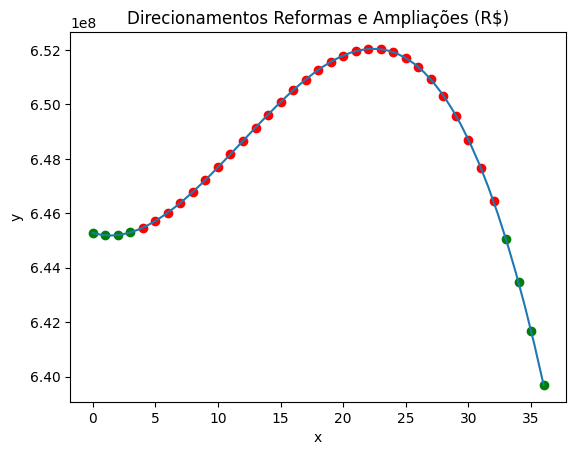

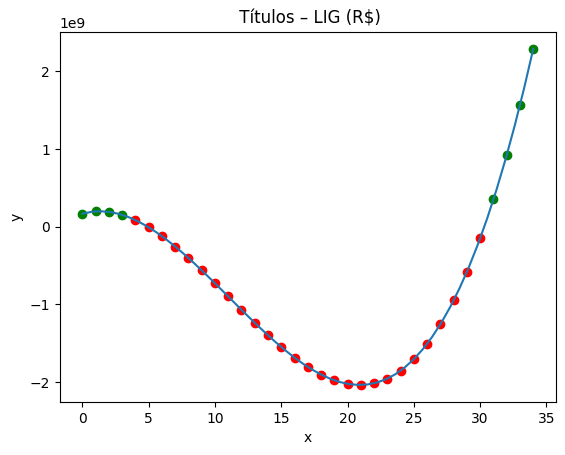

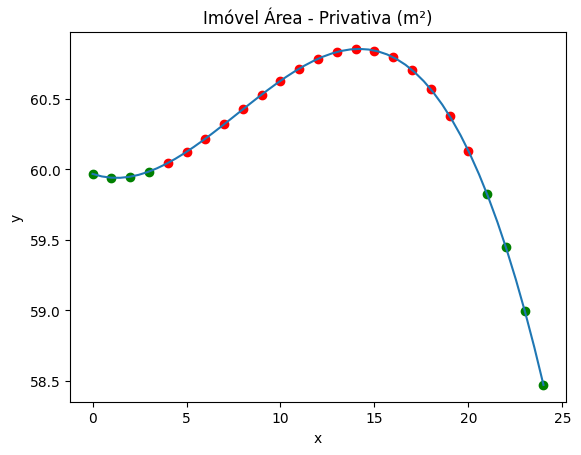

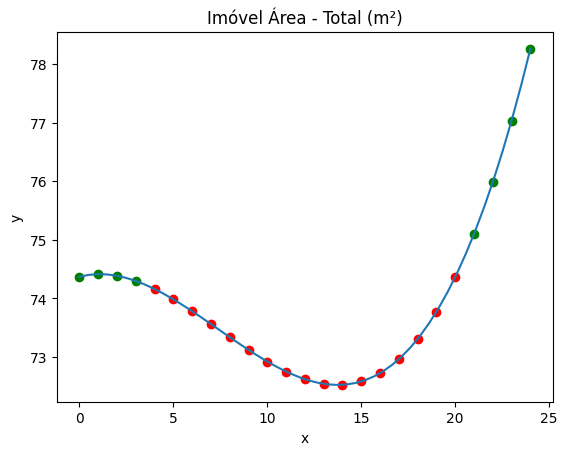

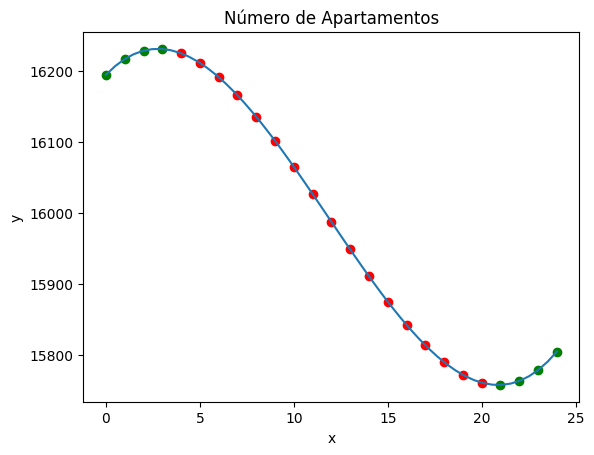

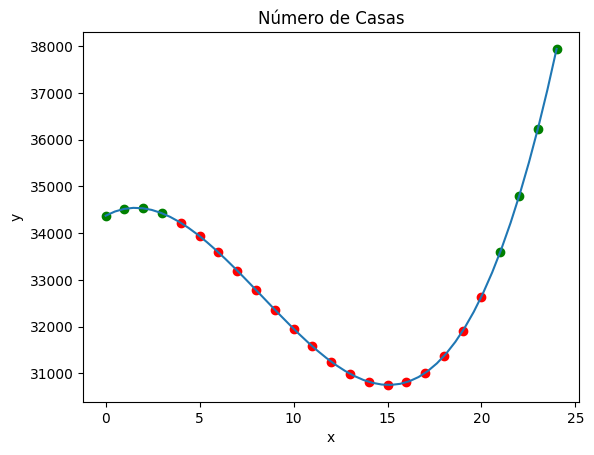

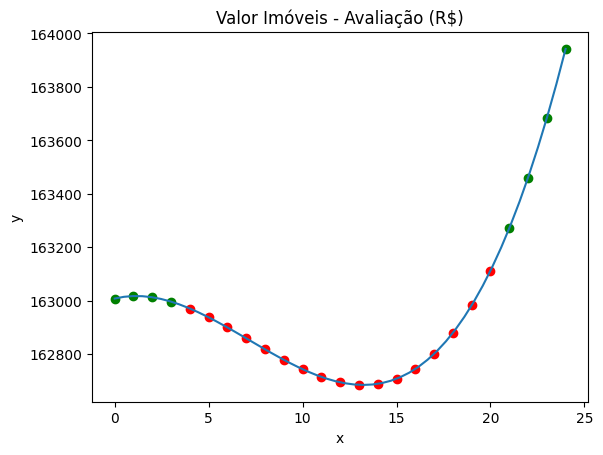

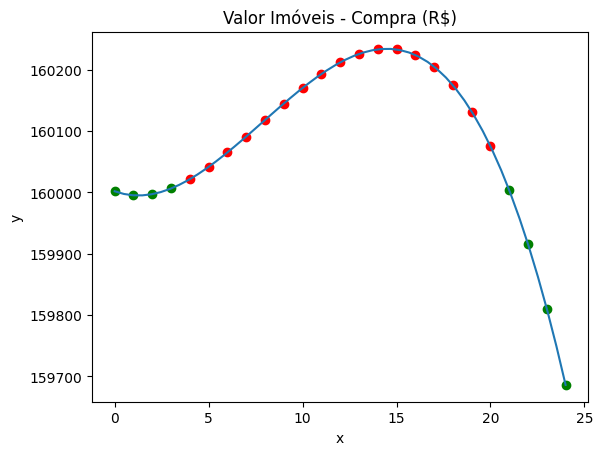

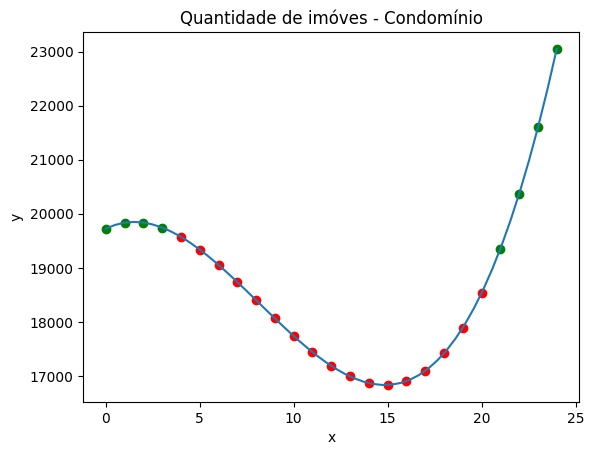

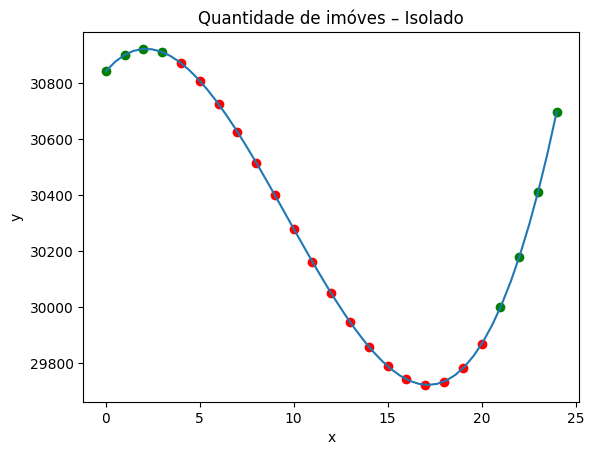

,DateTime,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
0,2014-04-30,4.863272e+07,2.362731e+08,1.744135e+09,3.410008e+09,4.050459e+09,9.326442e+07,8.721660e+07,3.594465e+08,4.590614e+08,3.379561e+11,2.394379e+10,6.452397e+08,3.608628e+11,1.844953e+07,1.065234e+09,1.928966e+09,9.095918e+09,9.901385e+09,1.720259e+07,4.591480e+08,4.853713e+07,4.763486e+08,1.137858e+09,1.171712e+10,6.952808e+10,1.596439e+11,2.136678e+11,1.205203e+09,4.704086e+09,2.688484e+10,2.701917e+10,1.479200,2.151600,1.533600,1.068000,4.922400,0.547600,0.924000,0.787200,0.166667,5.032143e+11,1.252395e+09,1.772018e+08,5.312773e+10,1.631743e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
1,2014-05-31,4.837710e+07,2.348003e+08,1.703774e+09,3.424106e+09,3.984114e+09,9.073734e+07,9.186696e+07,3.466802e+08,4.443605e+08,3.398667e+11,2.412265e+10,6.452397e+08,3.617657e+11,1.937544e+07,1.081813e+09,1.947628e+09,9.168369e+09,9.984318e+09,1.768091e+07,4.962114e+08,5.415478e+07,4.971051e+08,1.168312e+09,1.171251e+10,6.933758e+10,1.611786e+11,2.147953e+11,1.202299e+09,5.009590e+09,2.674872e+10,2.701402e+10,1.490000,2.147308,1.550000,1.086923,4.982308,0.596923,0.993077,0.841923,0.203182,5.028173e+11,1.248063e+09,1.772018e+08,5.358297e+10,1.641440e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
2,2014-06-30,4.799897e+07,2.368864e+08,1.664997e+09,3.439782e+09,3.939847e+09,8.858933e+07,1.028642e+08,3.438422e+08,4.322766e+08,3.417271e+11,2.429899e+10,6.452397e+08,3.626610e+11,2.017988e+07,1.095485e+09,1.964541e+09,9.233676e+09,1.005059e+10,1.821026e+07,5.266625e+08,6.590289e+07,5.152529e+08,1.196901e+09,1.170837e+10,6.916122e+10,1.627141e+11,2.158756e+11,1.202526e+09,5.425304e+09,2.651737e+10,2.699106e+10,1.486667,2.125926,1.554815,1.101481,5.004444,0.615926,1.049259,0.864444,0.236087,5.024632e+11,1.243328e+09,1.772018e+08,5.400900e+10,1.650652e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
3,2014-07-31,4.738457e+07,2.355100e+08,1.625718e+09,3.445528e+09,3.887305e+09,8.648221e+07,1.052493e+08,3.316529e+08,4.199326e+08,3.435761e+11,2.447281e+10,6.452397e+08,3.635371e+11,2.092644e+07,1.107778e+09,1.982493e+09,9.305294e+09,1.012950e+10,1.856002e+0

In [55]:
df_interpolated = read_csv_replace_missing_by_polynomial('dados_imobilidarios_bcb.csv', 0, 0)
df_interpolated

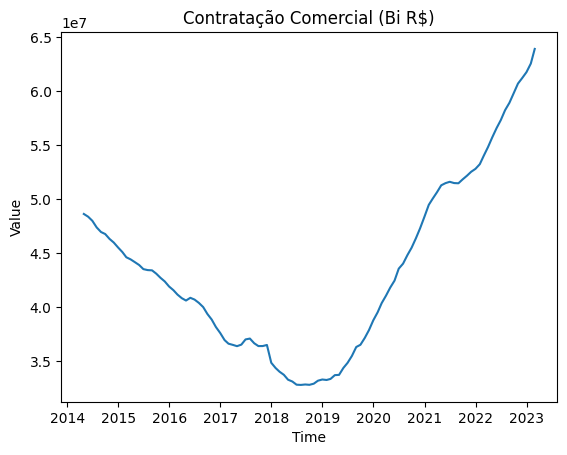

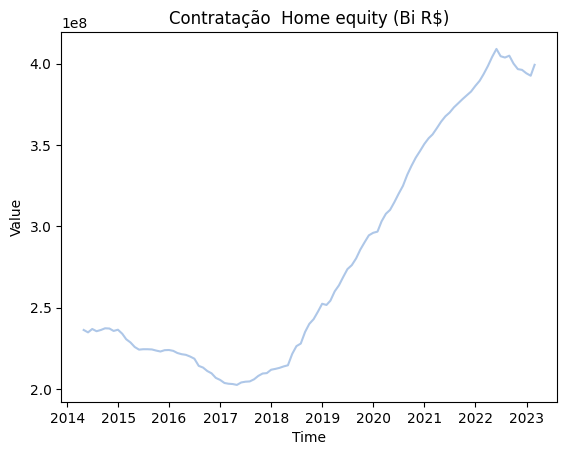

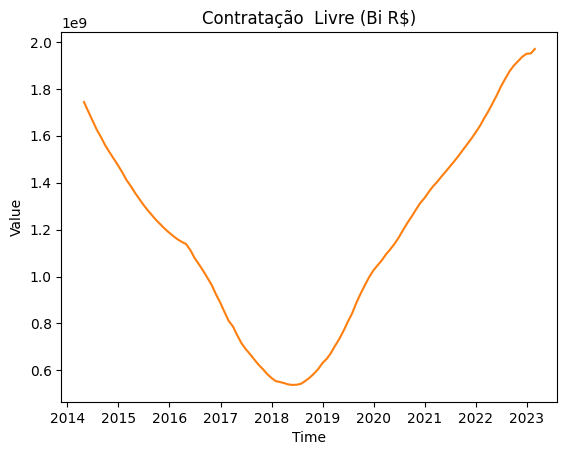

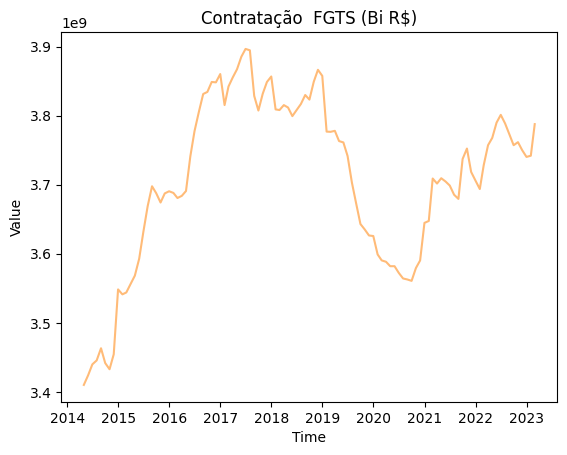

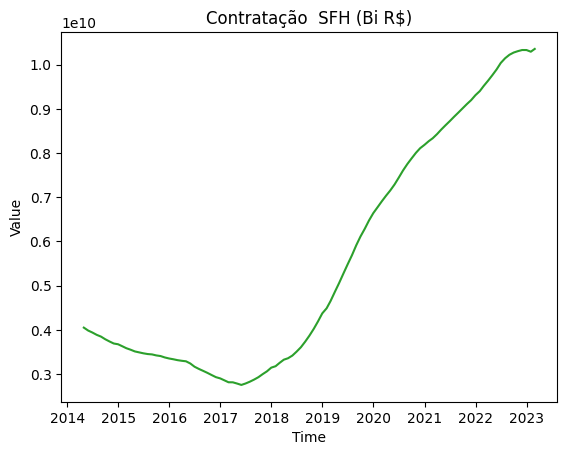

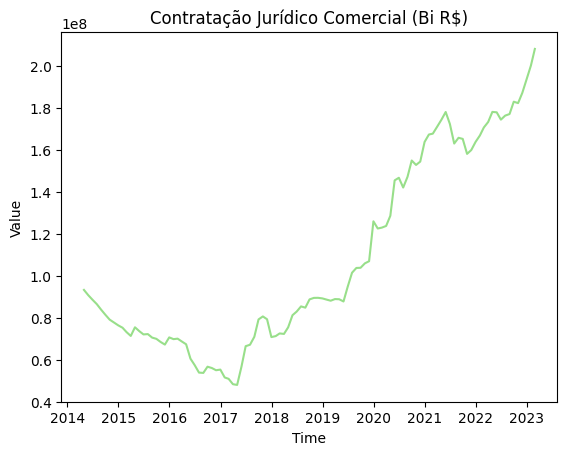

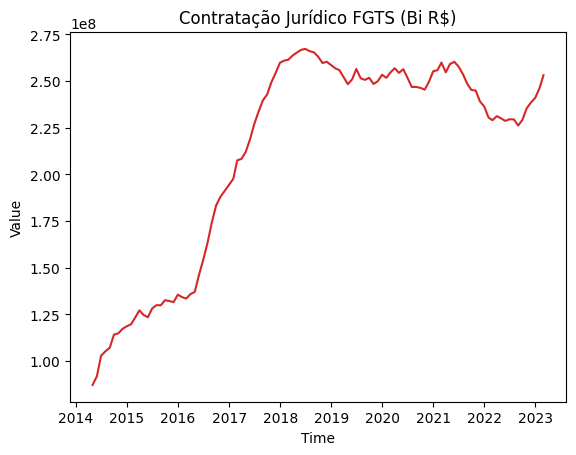

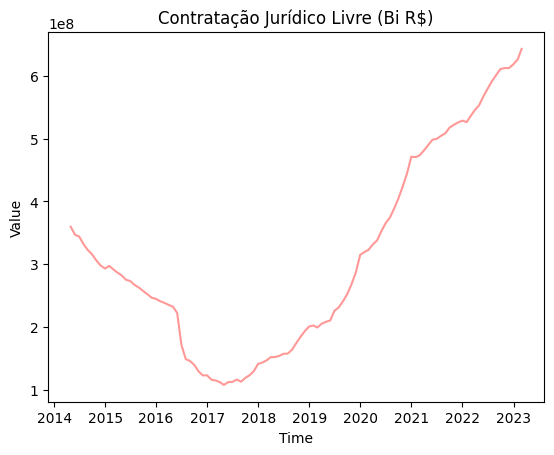

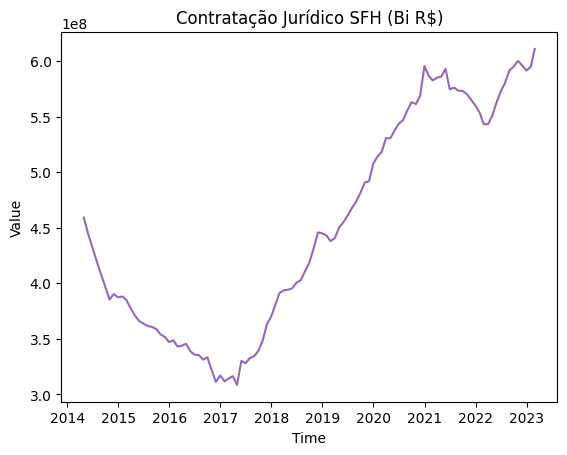

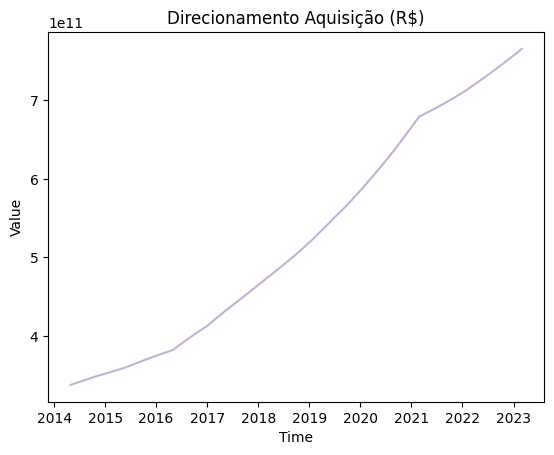

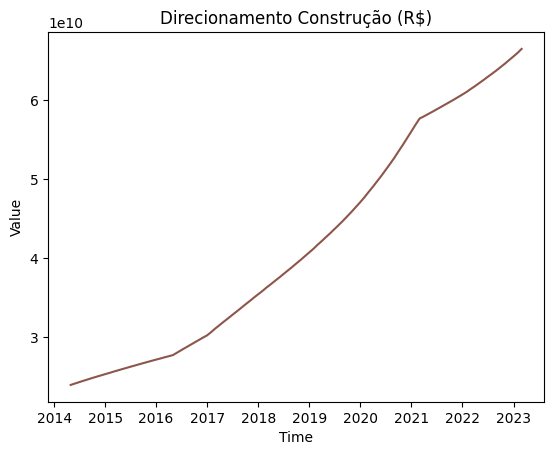

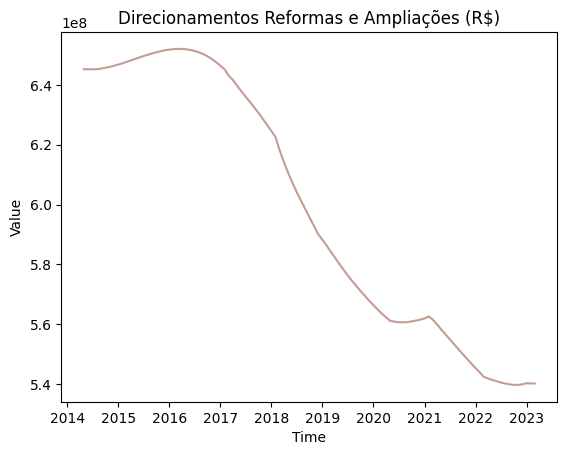

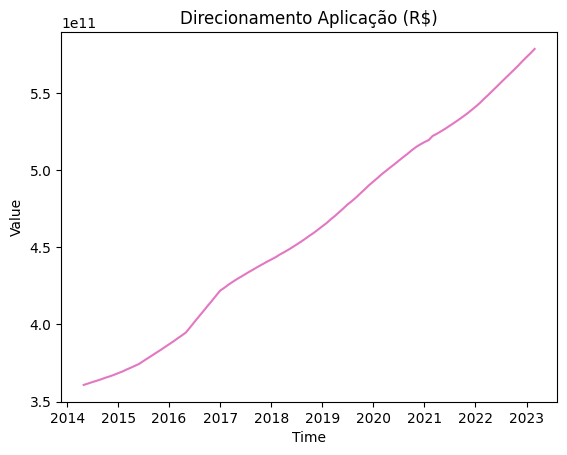

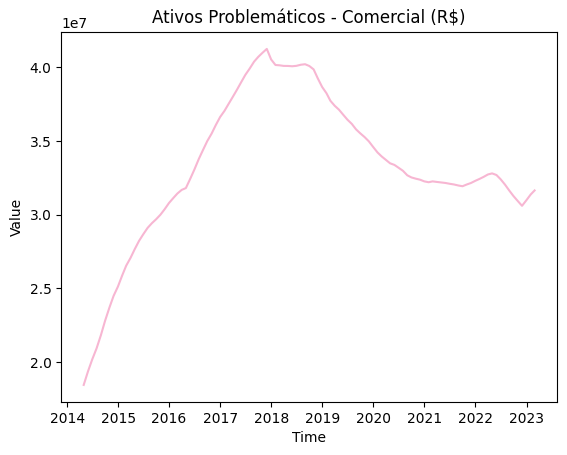

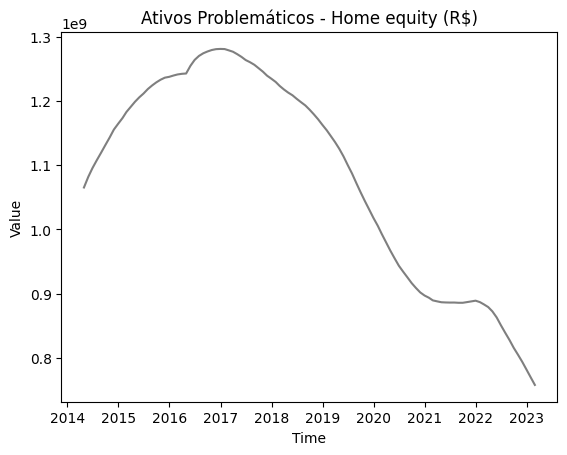

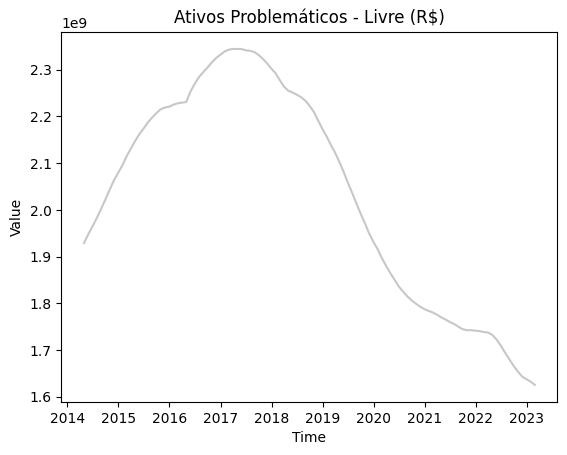

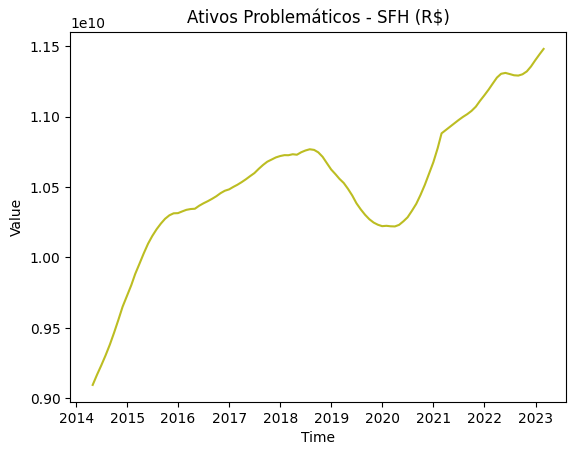

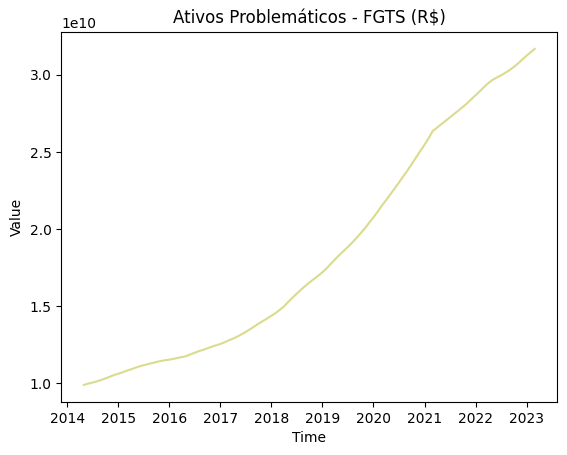

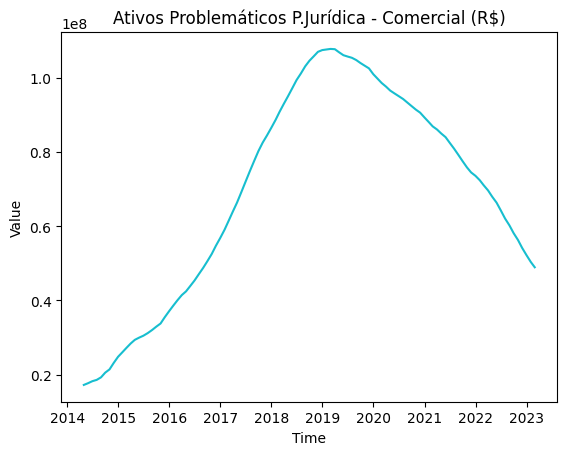

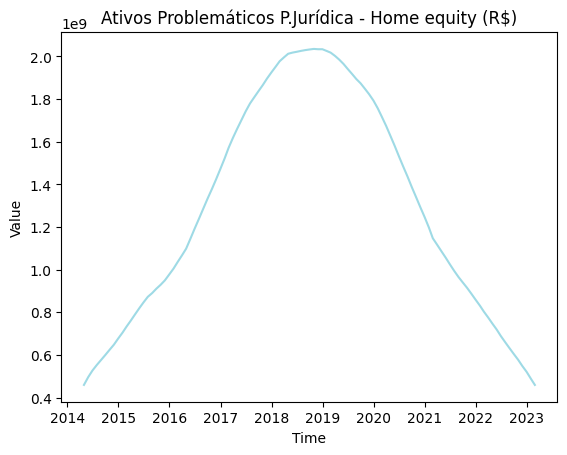

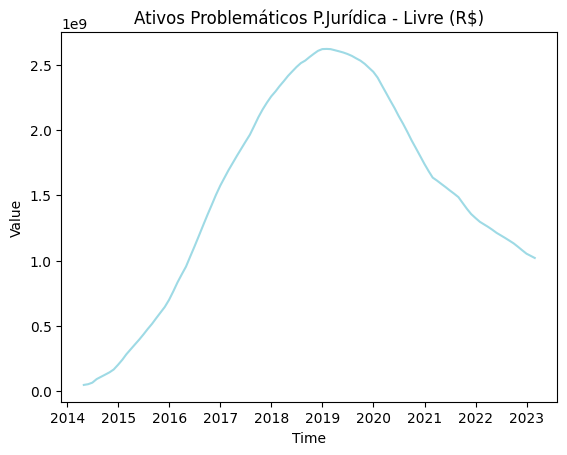

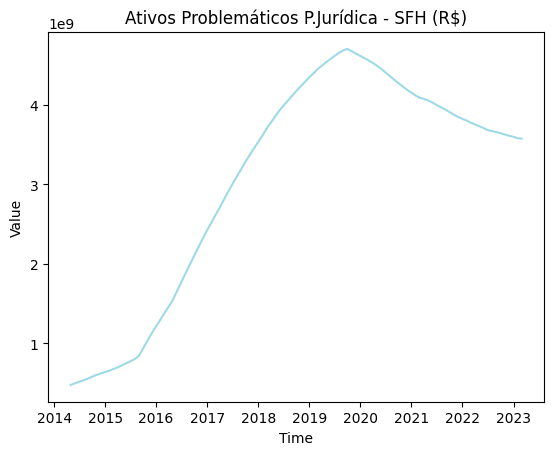

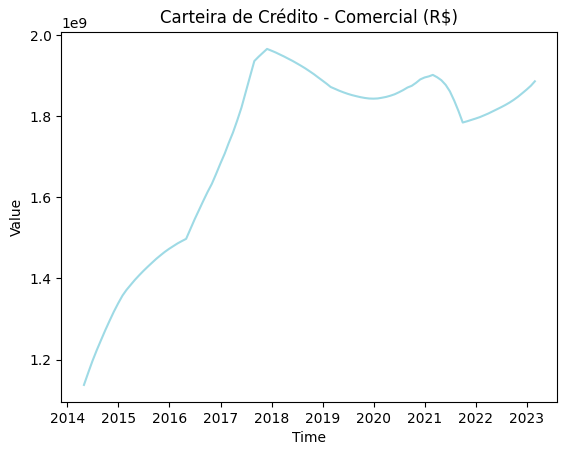

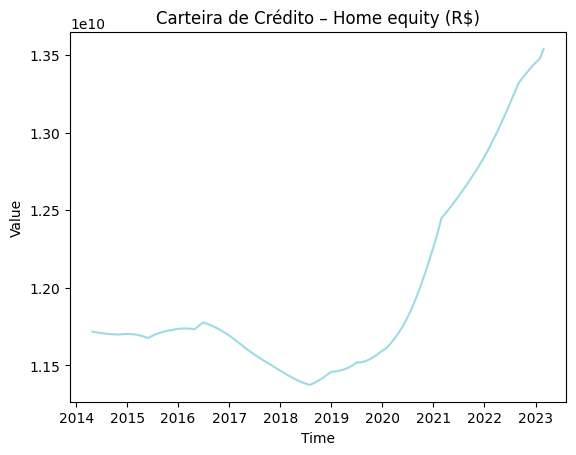

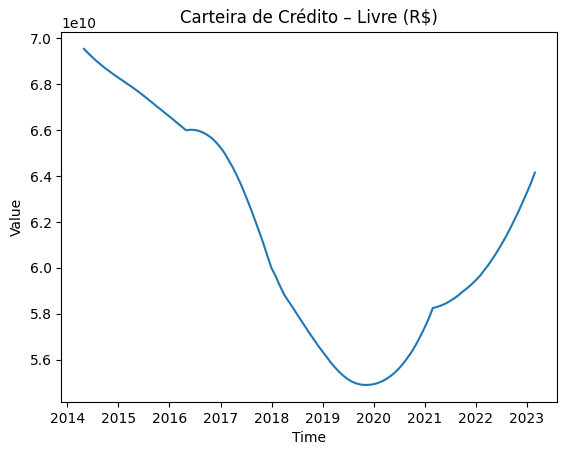

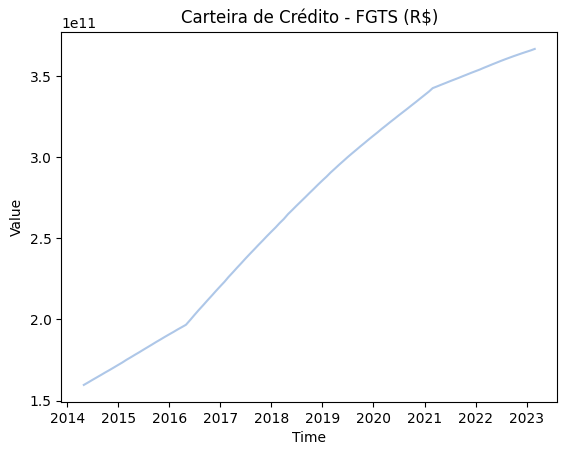

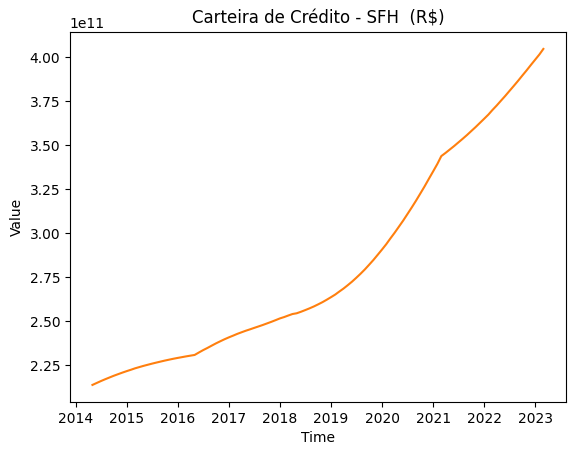

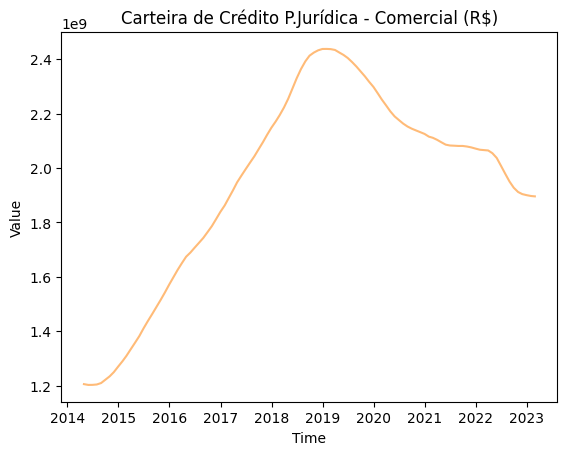

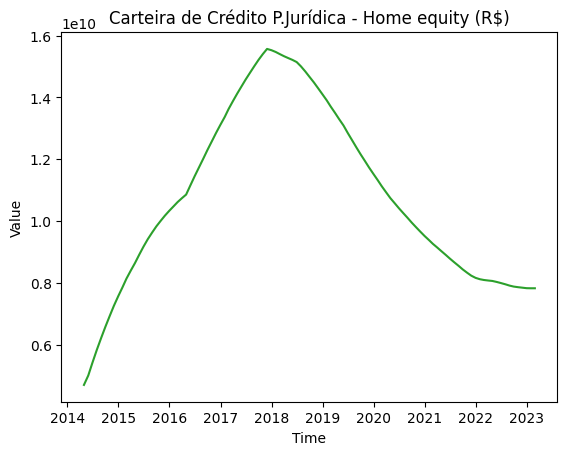

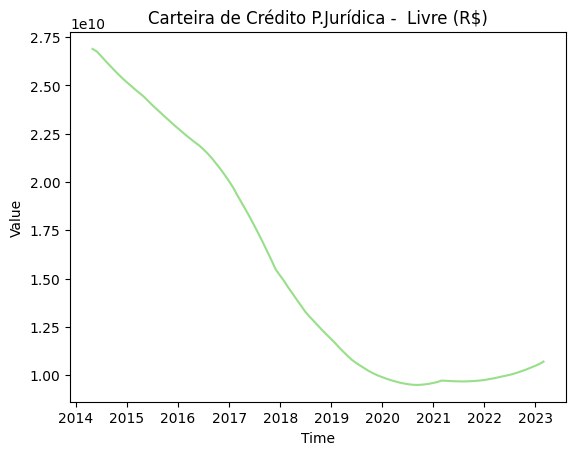

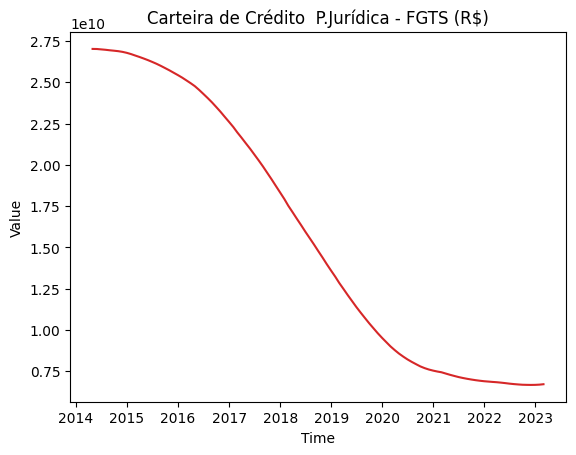

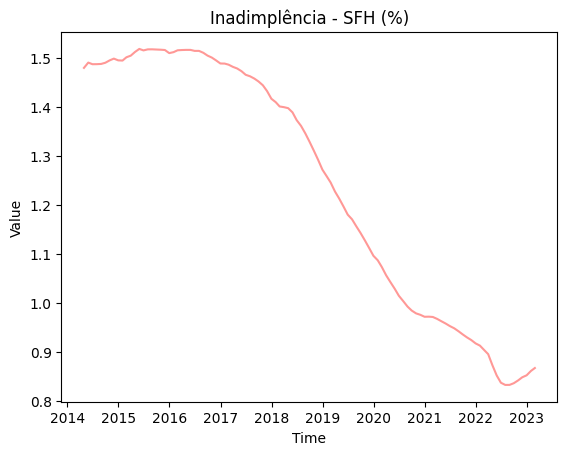

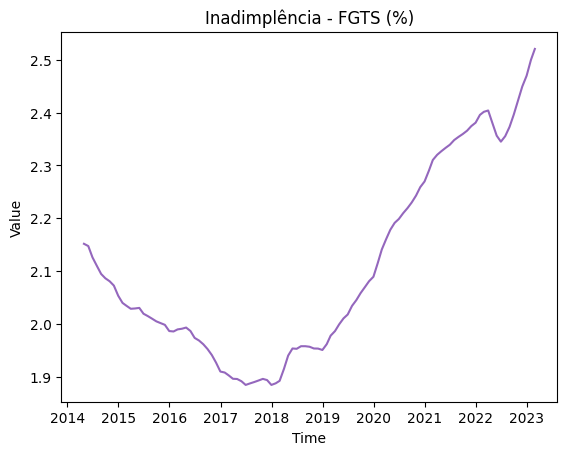

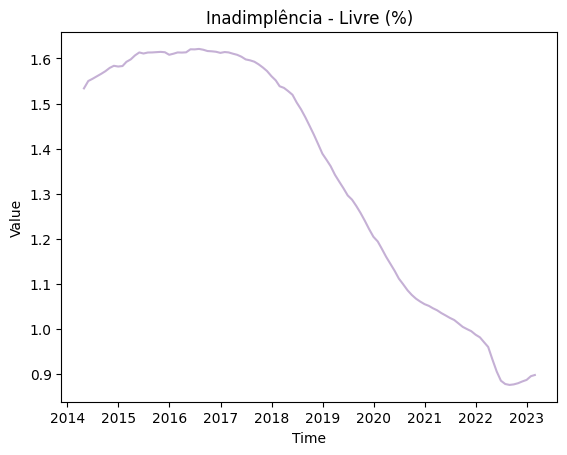

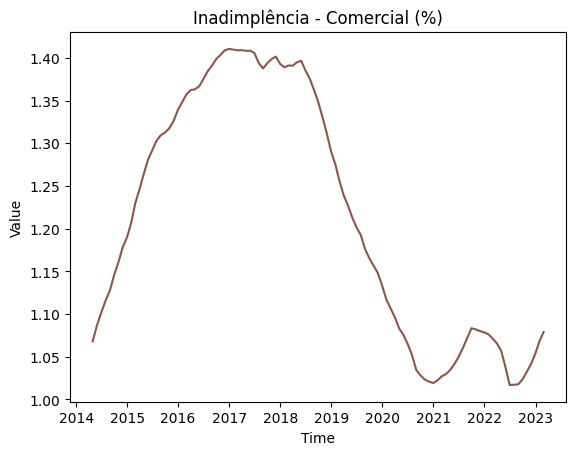

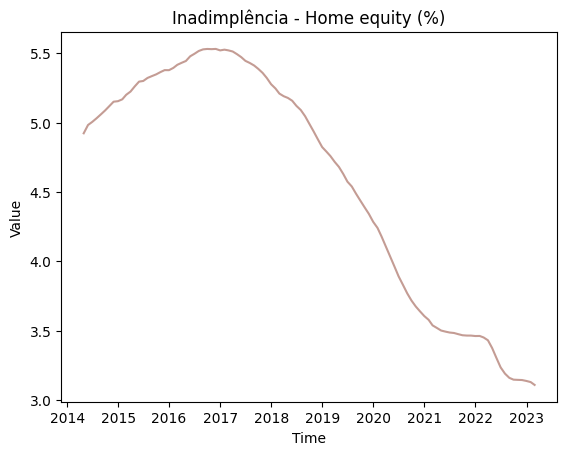

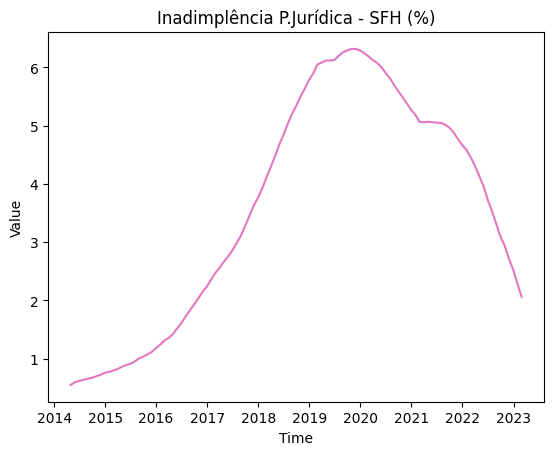

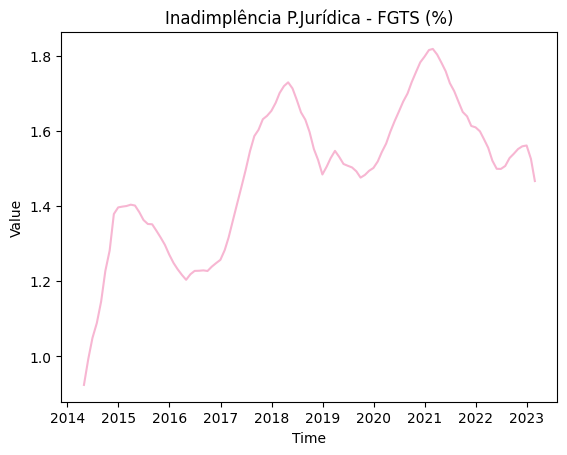

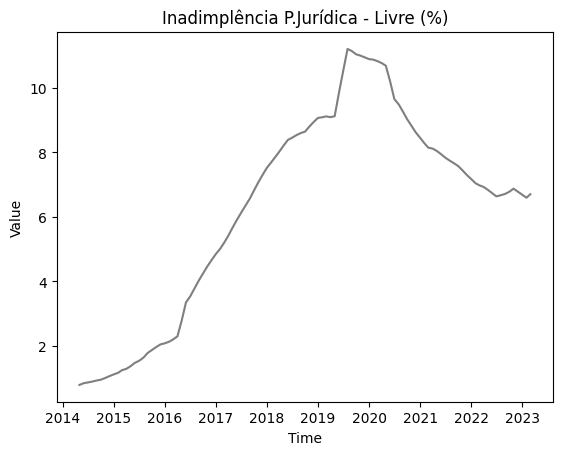

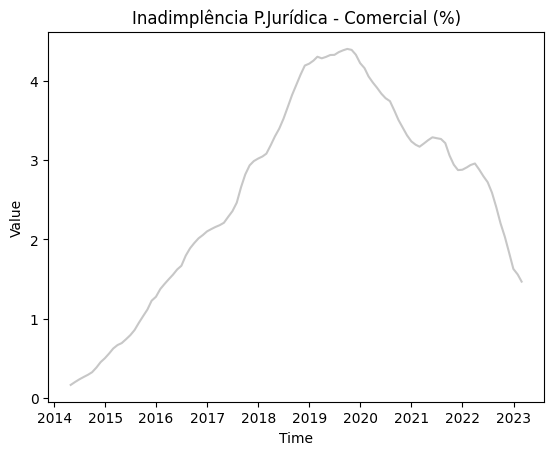

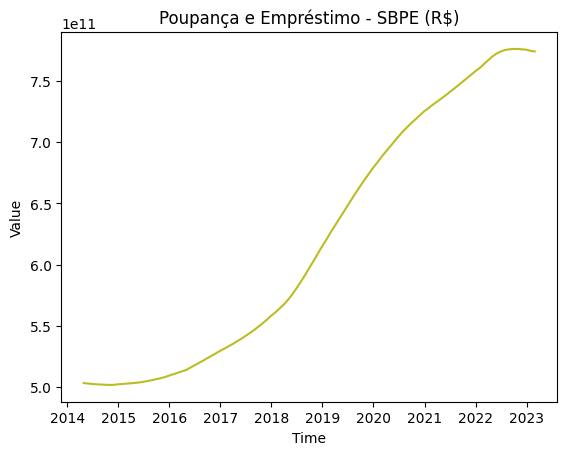

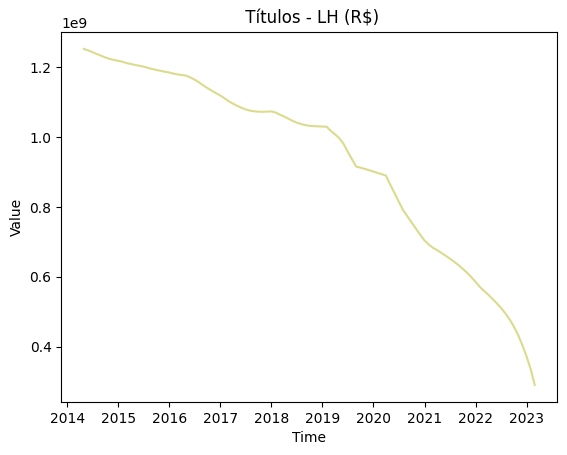

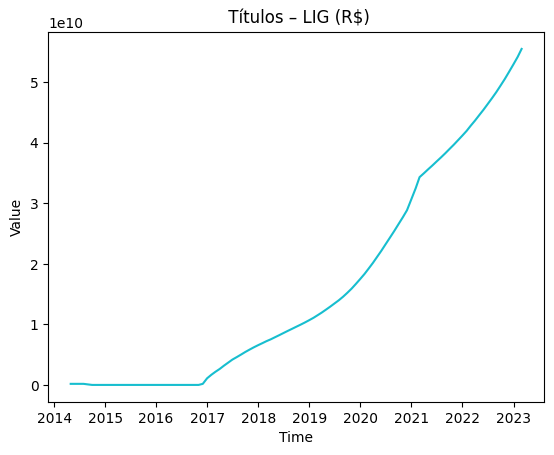

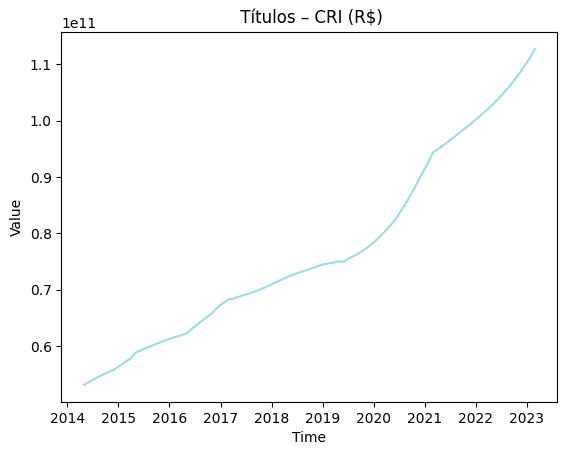

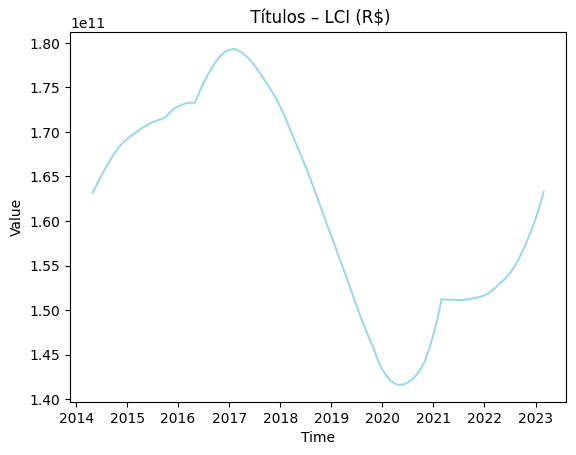

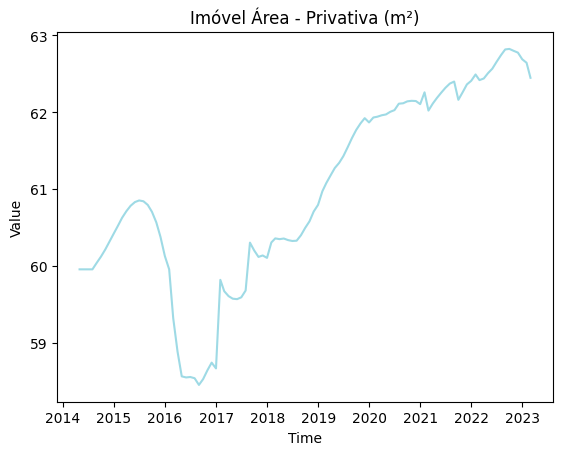

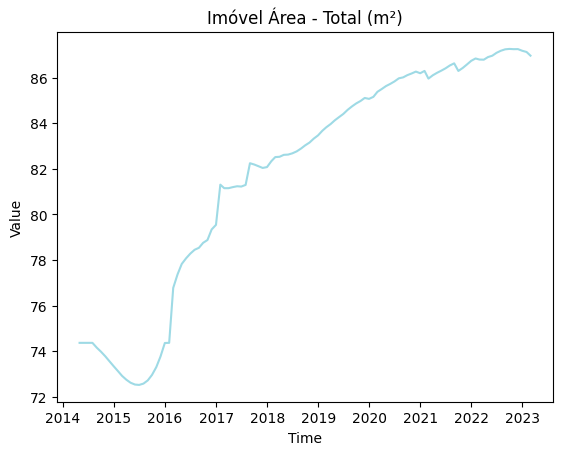

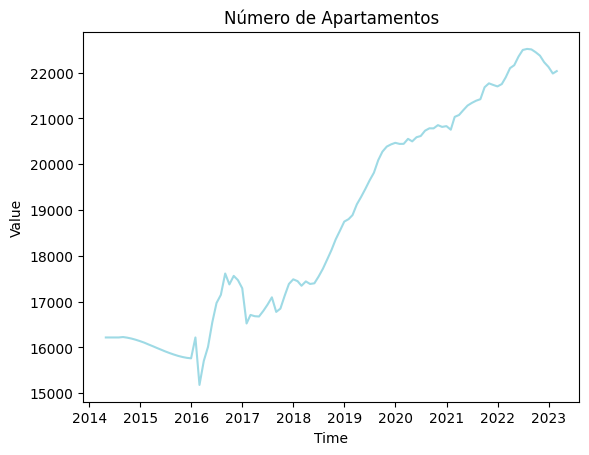

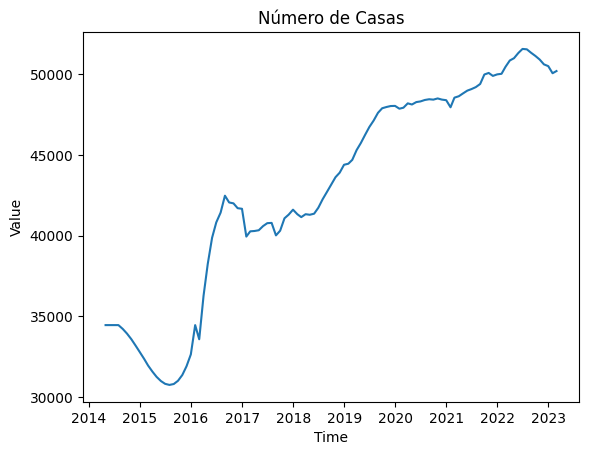

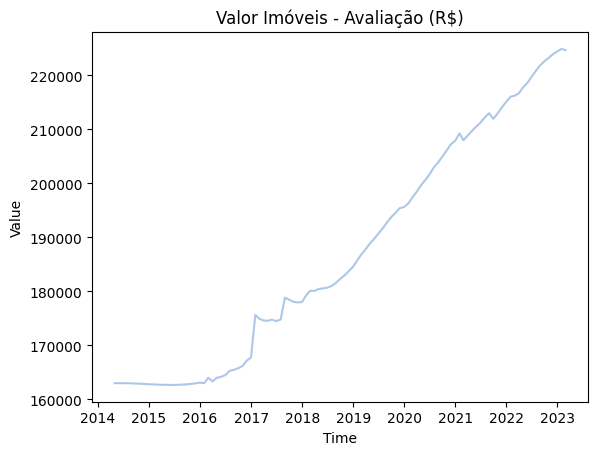

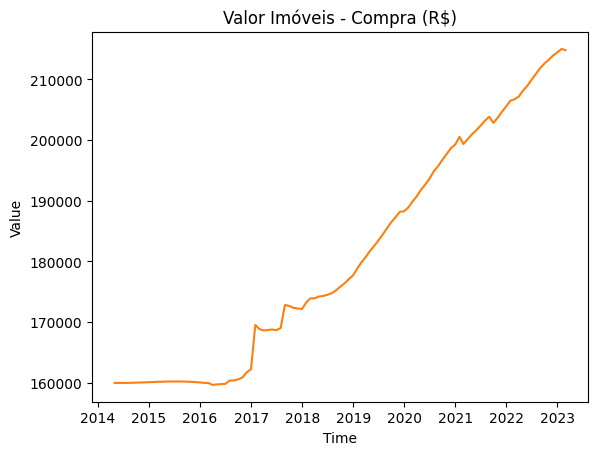

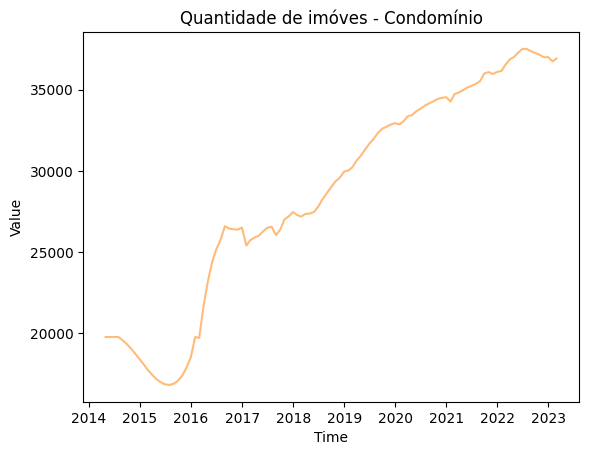

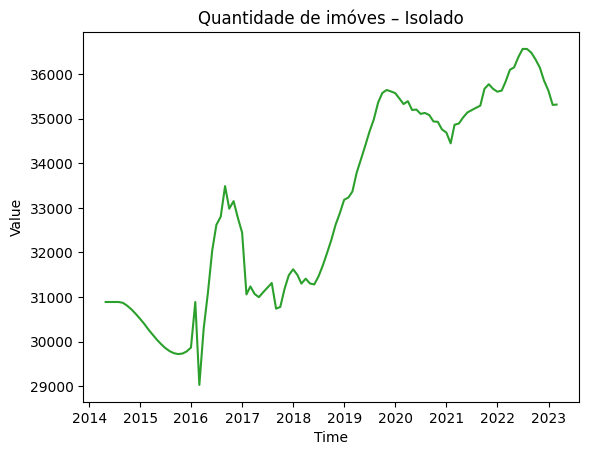

In [56]:
df_interpolated['DateTime'] = pd.to_datetime(df_interpolated['DateTime'])
df_interpolated.set_index('DateTime', inplace=True)
plot_columns(df_interpolated)